In [46]:
%matplotlib inline
import pymongo
from pymongo import MongoClient
import matplotlib
matplotlib.rcParams.update({'font.size': 32})
import matplotlib.pyplot as plt
import numpy
import scipy.ndimage
from pprint import pprint
from collections import defaultdict,OrderedDict
from datetime import datetime, timedelta
from functools import partial
import time
db = MongoClient('localhost').condor

In [76]:
db.condor_history.find_one({'EnteredCurrentStatus':{'$gte':time.mktime((2017,2,5,0,0,0,0,0,0)),
                                  '$lt':time.mktime((2017,2,14,0,0,0,0,0,0))},'Owner':'i3filter'})

{'BytesRecvd': 30418876.0,
 'BytesSent': 114502.0,
 'ClusterId': 34270450,
 'Cmd': '/scratch/i3filter/1903/iceprod_12046.1486265834.533242/iceprod.1903.12046.sh',
 'CommittedTime': 812,
 'CompletionDate': 1486274404,
 'CumulativeSlotTime': 812.0,
 'DiskUsage_RAW': 29710,
 'EnteredCurrentStatus': 1486274404,
 'ExecutableSize_RAW': 2,
 'ExitBySignal': False,
 'ExitCode': 0,
 'ExitStatus': 0,
 'GlobalJobId': 'sub-1.icecube.wisc.edu#34270450.0#1486265872',
 'ImageSize_RAW': 1658216,
 'JobCurrentStartDate': 1486273592,
 'JobStartDate': 1486273592,
 'JobStatus': 4,
 'LastJobStatus': 2,
 'LastRemoteHost': 'slot1@15125@node019.cm.cluster',
 'MATCH_EXP_JOBGLIDEIN_ResourceName': 'PHIDO_Dortmund',
 'NumJobStarts': 1,
 'NumShadowStarts': 1,
 'Owner': 'i3filter',
 'ProcId': 0,
 'QDate': 1486265872,
 'RemoteSysCpu': 3.0,
 'RemoteUserCpu': 46.0,
 'RemoteWallClockTime': 812.0,
 'RequestCpus': 1,
 'RequestDisk': 1000000,
 'RequestMemory': 4200,
 'Requestgpus': 0,
 'ResidentSetSize_RAW': 2044,
 'StartdP

In [37]:
def timekey(t):
    return datetime.fromtimestamp(t).strftime('%Y-%m-%d %H')
def make2list():
    return [0.,0.]                              
def make3list():
    return [0.,0.,0]                     

In [31]:
time.mktime((2017,2,15,1,0,0,0,0,0))-time.mktime((2017,2,15,0,0,0,0,0,0))

3600.0

In [139]:
projection = ['EnteredCurrentStatus',
              'RemoteWallClockTime',
              'ExitCode','ExitBySignal','ExitSignal','JobStatus','LastJobStatus',
              ]
start = time.mktime((2017,1,22,0,0,0,0,0,0))
end = time.mktime((2017,2,16,0,0,0,0,0,0))
filter = {'EnteredCurrentStatus':{'$gte':start,
                                  '$lt':end},
          'Owner':'i3filter',
         # 'Requestgpus':1,
         }
# by day
goodput = {timekey(t):[0.,0] for t in range(int(start),int(end),3600)}
badput = {timekey(t):[0.,0] for t in range(int(start),int(end),3600)}
start_time = time.time()
for i,row in enumerate(db.condor_history.find(filter=filter,projection=projection)):
    try:
        date = timekey(row['EnteredCurrentStatus'])
        if (not row['ExitBySignal']) and row['JobStatus'] == 4 and row['ExitCode'] == 0:
            goodput[date][0] += float(row['RemoteWallClockTime'])
            goodput[date][1] += 1
        else:
            badput[date][0] += float(row['RemoteWallClockTime'])
            badput[date][1] += 1
    except:
        print(row)
        raise
print(time.time()-start_time)

13.897305250167847


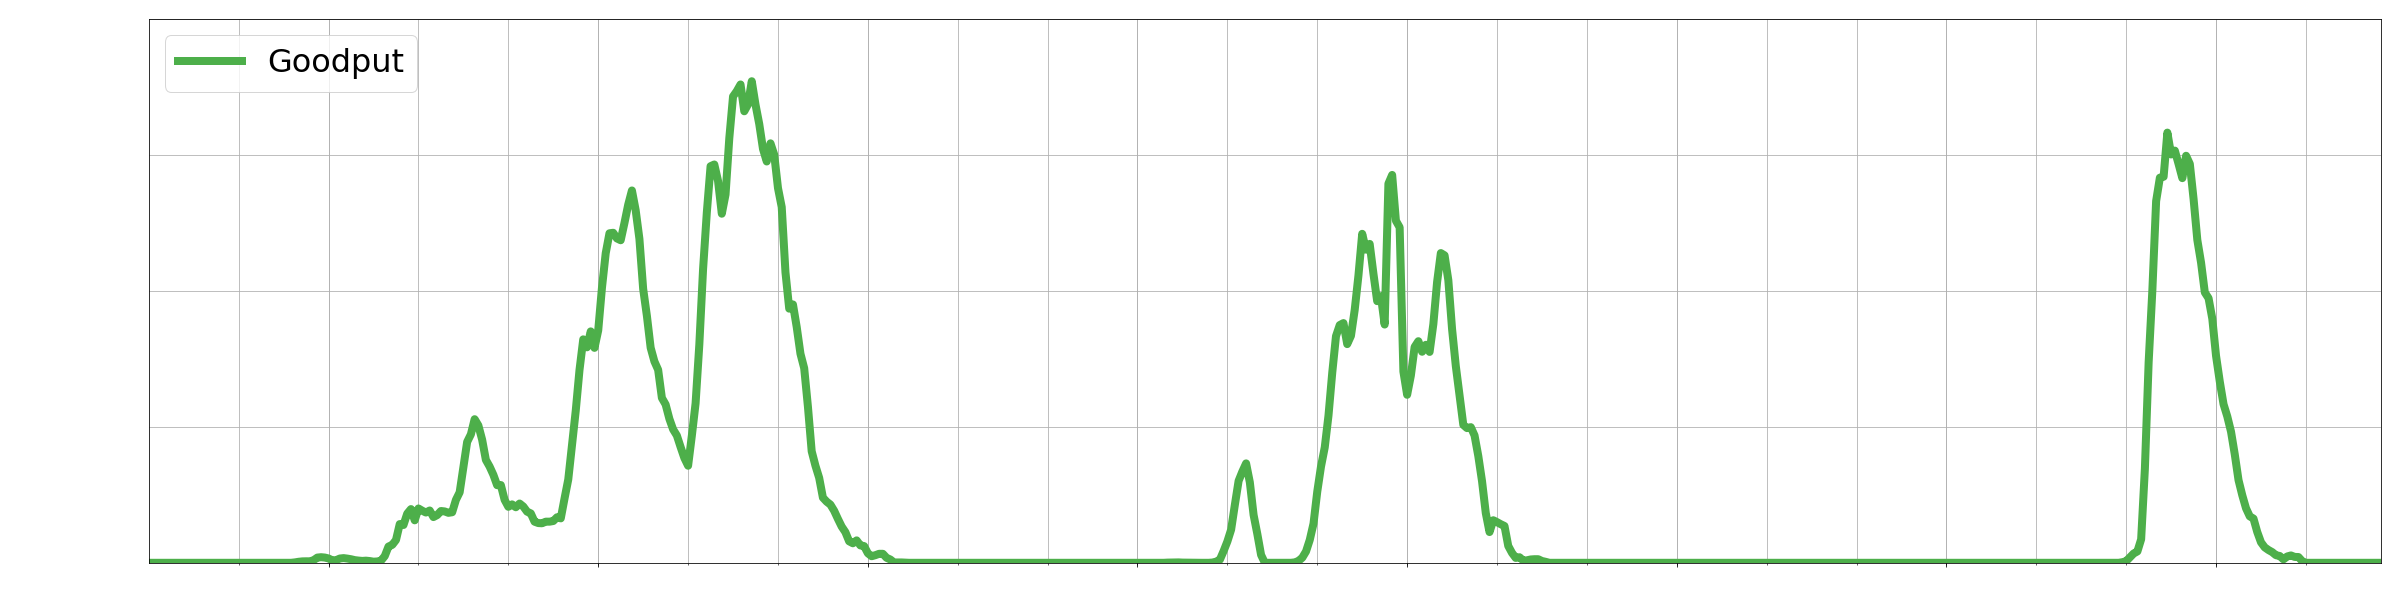

In [147]:
colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#a6cee3','#999999','#fb9a99',]

def moving_average(a, n=3) :
    ret = numpy.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

x = sorted(set(goodput))
xx = numpy.arange(len(x))

avg_window = 4
y1 = moving_average(numpy.array([goodput[d][0]/3600 if goodput[d][1] else 0 for d in x]),avg_window)
y2 = moving_average(numpy.array([badput[d][0]/3600 if badput[d][1] else 0 for d in x]),avg_window)
x = x[avg_window:-1*avg_window]
xx = xx[avg_window:-1*avg_window]

legend = ['Goodput','Badput']
plots = []
fig, ax = plt.subplots(figsize=(40, 10))
#ax.set_title(title,color='white',fontsize=60)
ax.set_yticks(list(range(0,4001,1000)))
ax.set_xticks([v for v in xx if v%24 == 0],minor=True)
ax.set_xticks([v for v in xx if (v+24)%72 == 0],minor=False)
ax.set_xticklabels([v.split()[0] for i,v in enumerate(x) if (xx[i]+24)%72 == 0], color='white')
ax.get_yaxis().set_tick_params(colors='white')
#ax.set_xlabel('Month', labelpad=10, color='white', fontsize=44)
ax.set_ylabel('CPUhours per hour', labelpad=10, color='white', fontsize=44)
ax.grid(b=True, which='major')
ax.get_xaxis().grid(b=True, which='minor')
ax.set_axisbelow(True)
plots.append(ax.plot(y1, color=colors[2], linewidth=8))
#plots.append(ax.plot(y2, color=colors[0], linewidth=8))
plt.xlim([0,len(xx)+avg_window])
plt.ylim([0,4000])
plt.legend(legend, loc='upper left')